# Expedia Personalised Hotel Searches
VU Data Mining Techniques 2024 | Assignment 2 | Group 17

## Imports

In [2]:
import datetime
import gc
import lightgbm as lgb
from lightgbm.callback import early_stopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.impute import KNNImputer
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\jaime\anaconda3\envs\DataMiningTechniques\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
def downscale_and_save(df, filename):
    df_copy = df.copy()

    for col in df_copy.select_dtypes(include='float64').columns:
        df_copy[col] = df_copy[col].astype('float32')

    df_copy.to_csv(filename, index=False)

    del df_copy
    gc.collect()

## Data Preprocessing

In [3]:
train_df = pd.read_csv('data/training_set_VU_DM.csv', parse_dates=['date_time'])
test_df = pd.read_csv('data/test_set_VU_DM.csv', parse_dates=['date_time'])

In [4]:
# Creating the relevance target
train_df['relevance'] = train_df['booking_bool'] * 2 + (train_df['click_bool'] * (1 - train_df['booking_bool']))

#### Handling Datetime

In [5]:
# Extract useful features from 'date_time'
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df = train_df.drop(columns=['date_time'])

test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['day'] = test_df['date_time'].dt.day
test_df = test_df.drop(columns=['date_time'])

#### Removing Outliers

In [6]:
num_feats_with_outliers = ['price_usd', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']

for feature in num_feats_with_outliers:  # Based on EDA only price_usd & compX_rate_percent_diff
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Replace outliers with NaN
    train_df.loc[~train_df[feature].between(lower_bound, upper_bound), feature] = np.nan

#### Selecting Subset of Records
Selecting a subset of records based on number of missing values in each record

In [7]:
# Calculate the count of missing values in each row
train_df['missing_count'] = train_df.isnull().sum(axis=1)

# Sort the dataframe by 'missing_count' in ascending order
train_df = train_df.sort_values(by='missing_count')

# Select the top x% of the rows with the least missing values
top_percentage = 0.75
cut_off = int(len(train_df) * top_percentage)
train_df = train_df.iloc[:cut_off]
print(len(train_df))

3718760


#### Handling Missing Values

In [8]:
# imputer = KNNImputer(n_neighbors=5)
# train_df[:] = imputer.fit_transform(train_df)

### Feature Engineering

#### Mean Position

In [9]:
mean_positions = train_df[train_df['random_bool'] == False].groupby('prop_id')['position'].mean().rename('mean_train_position')  # Exclude records where the results order is random
train_df = train_df.join(mean_positions, on='prop_id')
test_df = test_df.join(mean_positions, on='prop_id')

#### Click/Booking Prior Probability

In [10]:
def compute_prior(df, group_field, value_field):
    # Sum and count values per group
    sums = df.groupby(group_field)[value_field].transform('sum')
    count = df.groupby(group_field)[value_field].transform('count')
    
    # Calculate leave-one-out prior
    prior = (sums - df[value_field]) / (count - 1)
    return prior

In [11]:
# Apply function for click and booking bool
train_df['click_prior'] = compute_prior(train_df, 'prop_id', 'click_bool')
train_df['booking_prior'] = compute_prior(train_df, 'prop_id', 'booking_bool')

# Handling cases with only one record per group
train_df.fillna({'click_prior': train_df['click_bool'].mean()}, inplace=True)
train_df.fillna({'booking_prior': train_df['booking_bool'].mean()}, inplace=True)

In [12]:
# Priors for click and booking bool from the training set
test_df['click_prior'] = test_df['prop_id'].map(train_df.groupby('prop_id')['click_bool'].mean())
test_df['booking_prior'] = test_df['prop_id'].map(train_df.groupby('prop_id')['booking_bool'].mean())

# Handling cases with only one record per group
test_df.fillna({'click_prior': train_df['click_bool'].mean()}, inplace=True)
test_df.fillna({'booking_prior': train_df['booking_bool'].mean()}, inplace=True)

#### # of Prior Searches

In [13]:
# Number of occurences "minus the current row"
train_df['previous_searches'] = train_df.groupby('prop_id')['prop_id'].transform('count') - 1
test_df['previous_searches'] = test_df['prop_id'].map(train_df.value_counts('prop_id') - 1).fillna(0)

#### Number of Bookings for Property/Destination Combination

In [14]:
# Aggregate number of bookings for each property and destination combination
booking_counts = train_df.groupby(['prop_id', 'srch_destination_id'])['booking_bool'].sum().reset_index()
booking_counts.rename(columns={'booking_bool': 'booking_count'}, inplace=True)

# Merge this count back to the train and test datasets
train_df = train_df.merge(booking_counts, on=['prop_id', 'srch_destination_id'], how='left')
test_df = test_df.merge(booking_counts, on=['prop_id', 'srch_destination_id'], how='left')

#### Mean Distance to Other Properties in the Query

In [15]:
# Calculate the maximum difference in distance to the user within each search query
train_df['max_distance_diff'] = train_df.groupby('srch_id')['orig_destination_distance'].transform(lambda x: x.max() - x.min())

# Compute the mean of these maximum differences by property and add it back to the dataset
mean_distance = train_df.groupby('prop_id')['max_distance_diff'].mean().reset_index()
mean_distance.rename(columns={'max_distance_diff': 'mean_max_distance_diff'}, inplace=True)

train_df = train_df.merge(mean_distance, on='prop_id', how='left')
test_df = test_df.merge(mean_distance, on='prop_id', how='left')

#### Statistical Features

In [16]:
features_to_stat = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'orig_destination_distance', 'srch_query_affinity_score', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count']  # Perhaps change this based on LightGBM.feature_importances_

for feature in tqdm(features_to_stat):
    stats = train_df.groupby('prop_id')[feature].agg(['mean', 'median', 'std']).rename(
        columns={'mean': f'{feature}_mean', 'median': f'{feature}_median', 'std': f'{feature}_std'})
    train_df = train_df.join(stats, on='prop_id')

100%|██████████| 15/15 [00:57<00:00,  3.83s/it]


In [17]:
for feature in tqdm(features_to_stat):
    stats = train_df.groupby('prop_id')[feature].agg(['mean', 'median', 'std']).rename(
        columns={'mean': f'{feature}_mean', 'median': f'{feature}_median', 'std': f'{feature}_std'})
    test_df = test_df.join(stats, on='prop_id')

100%|██████████| 15/15 [01:33<00:00,  6.21s/it]


### Saving the Processed Data

In [18]:
downscale_and_save(train_df, 'data/processed_train.csv')
downscale_and_save(test_df, 'data/processed_test.csv')

# Modeling

In [3]:
train_df = pd.read_csv('data/processed_train.csv')
test_df = pd.read_csv('data/processed_test.csv')
train_df.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,srch_booking_window_std,srch_adults_count_mean,srch_adults_count_median,srch_adults_count_std,srch_children_count_mean,srch_children_count_median,srch_children_count_std,srch_room_count_mean,srch_room_count_median,srch_room_count_std
0,89120,16,31,3.66,270.28,219,4875,4,4.0,1,...,34.345734,1.782407,2.0,0.681737,0.277778,0.0,0.541802,1.115741,1.0,0.425744
1,89120,16,31,3.66,270.28,219,78838,4,4.5,1,...,43.731160,2.147643,2.0,0.936115,0.590571,0.0,0.836206,1.107940,1.0,0.344629
2,306756,5,219,3.50,189.36,219,126657,4,4.0,1,...,35.674164,1.887314,2.0,0.806867,0.294197,0.0,0.633165,1.102564,1.0,0.401222
3,199982,5,219,3.85,170.76,219,21155,3,3.0,0,...,37.193733,1.956463,2.0,0.982550,0.333333,0.0,0.673894,1.104762,1.0,0.381688
4,238357,16,31,3.59,140.17,219,138600,4,4.5,1,...,35.061028,1.903943,2.0,0.847642,0.422649,0.0,0.713755,1.125379,1.0,0.420205


#### Feature Grouping

In [4]:
boolean_features = ['prop_brand_bool', 'promotion_flag', 'srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool']
categorical_features = ['site_id', 'visitor_location_country_id', 'prop_country_id', 'srch_id', 'prop_id', 'srch_destination_id']
numerical_features = [col for col in train_df.columns if col not in boolean_features + categorical_features + ['relevance']]

In [5]:
missing_feats = set(train_df.columns) - set(test_df.columns)
missing_feats

{'booking_bool',
 'click_bool',
 'gross_bookings_usd',
 'max_distance_diff',
 'missing_count',
 'position',
 'relevance'}

In [6]:
features = train_df.columns.difference(['srch_id', 'prop_id', 'booking_bool', 'click_bool', 'relevance', 'Score'] + list(missing_feats))
for f in features:
    print(f)

booking_count
booking_prior
click_prior
comp1_inv
comp1_rate
comp1_rate_percent_diff
comp2_inv
comp2_rate
comp2_rate_percent_diff
comp3_inv
comp3_rate
comp3_rate_percent_diff
comp4_inv
comp4_rate
comp4_rate_percent_diff
comp5_inv
comp5_rate
comp5_rate_percent_diff
comp6_inv
comp6_rate
comp6_rate_percent_diff
comp7_inv
comp7_rate
comp7_rate_percent_diff
comp8_inv
comp8_rate
comp8_rate_percent_diff
day
mean_max_distance_diff
mean_train_position
month
orig_destination_distance
orig_destination_distance_mean
orig_destination_distance_median
orig_destination_distance_std
previous_searches
price_usd
price_usd_mean
price_usd_median
price_usd_std
promotion_flag
prop_brand_bool
prop_country_id
prop_location_score1
prop_location_score1_mean
prop_location_score1_median
prop_location_score1_std
prop_location_score2
prop_location_score2_mean
prop_location_score2_median
prop_location_score2_std
prop_log_historical_price
prop_log_historical_price_mean
prop_log_historical_price_median
prop_log_histori

In [7]:
# Grouping by 'srch_id' before splitting to maintain groups
grouped = train_df.groupby('srch_id')
gss = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_inds, val_inds = next(gss.split(train_df, groups=train_df['srch_id']))

In [8]:
# Group sizes for LightGBM
train_group = train_df.iloc[train_inds].groupby('srch_id').size().values
val_group = train_df.iloc[val_inds].groupby('srch_id').size().values

In [9]:
X_train, y_train = train_df[features].iloc[train_inds], train_df['relevance'].iloc[train_inds]
X_val, y_val = train_df[features].iloc[val_inds], train_df['relevance'].iloc[val_inds]
X_test = test_df[features]

assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

In [10]:
param_grid = {
    'learning_rate': [0.01, 0.05],
    'subsample': [0.5, 0.8, 1],
    'n_estimators':  [1,10,50,100,200]
}

In [12]:
# categorical features should be the categorical features minus the ones that are not in the features
categorical_features = [f for f in categorical_features if f in features]
best_score = -float('inf')
best_params = {}

# Iterate over all combinations of parameters
for params in tqdm(ParameterGrid(param_grid)):
    model = lgb.LGBMRanker(
        objective='lambdarank',
        boosting_type='dart',
        importance_type='gain',
        metric='ndcg',
        label_gain=[0, 1, 10],
        num_leaves=15,
        n_estimators=50,
        reg_alpha=0.2,
        reg_lambda=0.2,
        verbose=0,
        **params
    )
    model.fit(
        X_train,
        y_train,
        group=train_group,
        eval_set=[(X_val, y_val)],
        eval_group=[val_group],
        eval_at=[5],
        categorical_feature=categorical_features,
        # callbacks=[early_stopping(10)]
    )
    
    # Evaluate the model
    y_pred_val = model.predict(X_val)
    score = ndcg_score([y_val], [y_pred_val])

    # Save the best model
    if score > best_score:
        best_score = score
        best_params = params
        model.booster_.save_model('best_lambdaMART_model.txt')


print('-' * 50)
print(f'Best NDCG Score: {best_score}')
print(f'Best Parameters: {best_params}')

  0%|          | 0/30 [00:00<?, ?it/s]

<class 'dict'>


c:\Users\jaime\anaconda3\envs\DataMiningTechniques\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jaime\anaconda3\envs\DataMiningTechniques\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


  3%|▎         | 1/30 [00:36<17:27, 36.13s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


  7%|▋         | 2/30 [00:48<10:27, 22.43s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 10%|█         | 3/30 [01:00<07:51, 17.47s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 13%|█▎        | 4/30 [01:14<06:56, 16.03s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 17%|█▋        | 5/30 [01:28<06:20, 15.21s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 20%|██        | 6/30 [01:42<05:55, 14.81s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 23%|██▎       | 7/30 [02:14<07:50, 20.45s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 27%|██▋       | 8/30 [02:48<09:06, 24.84s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 30%|███       | 9/30 [03:19<09:24, 26.89s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 33%|███▎      | 10/30 [04:20<12:23, 37.17s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 37%|███▋      | 11/30 [05:19<13:55, 43.95s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 40%|████      | 12/30 [06:20<14:44, 49.15s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 43%|████▎     | 13/30 [08:40<21:46, 76.84s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 47%|████▋     | 14/30 [11:01<25:37, 96.07s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 50%|█████     | 15/30 [13:20<27:16, 109.08s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 53%|█████▎    | 16/30 [13:30<18:30, 79.30s/it] 

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 57%|█████▋    | 17/30 [13:40<12:38, 58.35s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 60%|██████    | 18/30 [13:50<08:44, 43.74s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 63%|██████▎   | 19/30 [14:03<06:20, 34.58s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 67%|██████▋   | 20/30 [14:16<04:42, 28.22s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 70%|███████   | 21/30 [14:30<03:35, 23.94s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 73%|███████▎  | 22/30 [15:01<03:27, 25.95s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 77%|███████▋  | 23/30 [15:34<03:17, 28.15s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 80%|████████  | 24/30 [16:05<02:54, 29.04s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 83%|████████▎ | 25/30 [17:14<03:24, 40.86s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 87%|████████▋ | 26/30 [18:14<03:06, 46.56s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 90%|█████████ | 27/30 [19:16<02:33, 51.17s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 93%|█████████▎| 28/30 [21:40<02:38, 79.12s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


 97%|█████████▋| 29/30 [24:02<01:37, 97.92s/it]

<class 'dict'>
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


100%|██████████| 30/30 [26:24<00:00, 52.81s/it] 

--------------------------------------------------
Best NDCG Score: 0.892507374819291
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'subsample': 0.8}


In [15]:
X_train

,booking_count,booking_prior,click_prior,comp1_inv,comp1_rate,comp1_rate_percent_diff,comp2_inv,comp2_rate,comp2_rate_percent_diff,comp3_inv,...,visitor_hist_adr_usd,visitor_hist_adr_usd_mean,visitor_hist_adr_usd_median,visitor_hist_adr_usd_std,visitor_hist_starrating,visitor_hist_starrating_mean,visitor_hist_starrating_median,visitor_hist_starrating_std,visitor_location_country_id,year
2,21,0.039163,0.061445,0.0,1.0,15.0,0.0,0.0,6.0,0.0,...,189.36,231.51617,215.875,89.465390,3.50,3.596489,3.620,0.602721,219,2013
3,30,0.076294,0.103542,0.0,1.0,16.0,0.0,0.0,9.0,0.0,...,170.76,217.64044,189.060,94.510270,3.85,3.427778,3.520,0.650265,219,2013
4,8,0.025304,0.037449,0.0,0.0,18.0,0.0,-1.0,15.0,0.0,...,140.17,230.08704,207.340,94.565360,3.59,3.517031,3.620,0.595722,31,2013
5,13,0.050654,0.070261,0.0,0.0,18.0,0.0,0.0,5.0,0.0,...,277.64,221.44156,205.160,92.324920,4.22,3.504889,3.540,0.542941,219,2013
6,1,0.027650,0.055300,0.0,0.0,11.0,0.0,0.0,13.0,0.0,...,101.11,176.84636,161.850,80.418330,2.00,3.011818,3.000,0.675690,219,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3718755,5,0.050847,0.067797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,165.38167,175.510,45.664284,NaN,2.781667,2.875,0.328111,100,2013
3718756,0,0.049180,0.114754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,165.66000,159.770,48.893887,NaN,3.477500,3.670,0.645396,220,2013
3718757,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,155.36000,155.360,35.765460,NaN,3.750000,3.750,0.098995,220,2013
3718758,1,0.066667,0.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,211.66000,211.660,NaN,NaN,3.700000,3.700,NaN,220,2013


## hyper-parameter search

In [36]:
categorical_features = ['site_id',
 'visitor_location_country_id',
 'prop_country_id',
 'srch_destination_id']

In [47]:
import optuna
import lightgbm as lgb
    
def objective(trial):
    """Train Light GBM model"""

    ranking_param_grid = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08, step=0.01),
        'n_estimators': trial.suggest_int('n_estimators', 10, 50, step=2),
        'num_leaves': trial.suggest_int('num_leaves', 10, 30, 2),
        'max_depth': trial.suggest_int('max_depth', 0, 100, 5)
    }
    
    gbm = lgb.LGBMRanker(
        objective='lambdarank',
        boosting_type='dart',
        importance_type='gain',
        metric='ndcg',
        label_gain=[0, 1, 10],
        reg_alpha=0.2,
        reg_lambda=0.2,
        verbose=0,
        **ranking_param_grid
    )
    
    gbm.fit(
        X_train,
        y_train,
        group=train_group,
        eval_set=[(X_val, y_val)],
        eval_group=[val_group],
        eval_at=[5],
        categorical_feature=categorical_features,
        feature_name= list(features)
        # callbacks=[early_stopping(10)]
    )
    
    return list(gbm.best_score_['valid_0'].values())

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_trial.value)


[I 2024-05-18 22:51:30,332] A new study created in memory with name: no-name-bcce26f3-4381-47e6-8423-7a37b3369c81


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:52:01,305] Trial 0 finished with value: 0.7663678527443015 and parameters: {'learning_rate': 0.05, 'n_estimators': 42, 'num_leaves': 28, 'max_depth': 85}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:52:29,533] Trial 1 finished with value: 0.750148205299846 and parameters: {'learning_rate': 0.03, 'n_estimators': 40, 'num_leaves': 20, 'max_depth': 60}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:52:45,883] Trial 2 finished with value: 0.7389633623415885 and parameters: {'learning_rate': 0.01, 'n_estimators': 18, 'num_leaves': 20, 'max_depth': 50}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:53:09,856] Trial 3 finished with value: 0.7398861930572377 and parameters: {'learning_rate': 0.02, 'n_estimators': 38, 'num_leaves': 14, 'max_depth': 95}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:53:31,021] Trial 4 finished with value: 0.7484319900008378 and parameters: {'learning_rate': 0.03, 'n_estimators': 30, 'num_leaves': 22, 'max_depth': 35}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:53:49,306] Trial 5 finished with value: 0.7594006362614814 and parameters: {'learning_rate': 0.08, 'n_estimators': 26, 'num_leaves': 18, 'max_depth': 85}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:54:18,752] Trial 6 finished with value: 0.7438802516311191 and parameters: {'learning_rate': 0.01, 'n_estimators': 46, 'num_leaves': 22, 'max_depth': 40}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:54:39,679] Trial 7 finished with value: 0.7646619103141881 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 28, 'num_leaves': 26, 'max_depth': 45}. Best is trial 0 with value: 0.7663678527443015.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:55:07,914] Trial 8 finished with value: 0.7692239318460017 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 46, 'num_leaves': 18, 'max_depth': 70}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:55:23,599] Trial 9 finished with value: 0.7574389688686562 and parameters: {'learning_rate': 0.08, 'n_estimators': 18, 'num_leaves': 24, 'max_depth': 10}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:55:49,579] Trial 10 finished with value: 0.7516933622375954 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 48, 'num_leaves': 10, 'max_depth': 70}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:56:16,450] Trial 11 finished with value: 0.7676717359044731 and parameters: {'learning_rate': 0.05, 'n_estimators': 40, 'num_leaves': 30, 'max_depth': 80}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:56:46,176] Trial 12 finished with value: 0.7582965926451044 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 16, 'max_depth': 70}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:57:11,397] Trial 13 finished with value: 0.7686532419325557 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 36, 'num_leaves': 30, 'max_depth': 100}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:57:32,629] Trial 14 finished with value: 0.7535795212346844 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 34, 'num_leaves': 12, 'max_depth': 100}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:57:46,666] Trial 15 finished with value: 0.7501214324573073 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 12, 'num_leaves': 30, 'max_depth': 0}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:58:08,657] Trial 16 finished with value: 0.7606848337091442 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 34, 'num_leaves': 16, 'max_depth': 100}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:58:37,897] Trial 17 finished with value: 0.761075204991165 and parameters: {'learning_rate': 0.04, 'n_estimators': 44, 'num_leaves': 26, 'max_depth': 25}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:59:00,003] Trial 18 finished with value: 0.7607310987730566 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 34, 'num_leaves': 18, 'max_depth': 60}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:59:18,076] Trial 19 finished with value: 0.7646898405749626 and parameters: {'learning_rate': 0.08, 'n_estimators': 24, 'num_leaves': 24, 'max_depth': 75}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 22:59:46,778] Trial 20 finished with value: 0.751357697000379 and parameters: {'learning_rate': 0.04, 'n_estimators': 50, 'num_leaves': 14, 'max_depth': 90}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:00:12,599] Trial 21 finished with value: 0.7666305827565705 and parameters: {'learning_rate': 0.05, 'n_estimators': 38, 'num_leaves': 30, 'max_depth': 80}. Best is trial 8 with value: 0.7692239318460017.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:00:41,590] Trial 22 finished with value: 0.7705638180409446 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 44, 'num_leaves': 28, 'max_depth': 60}. Best is trial 22 with value: 0.7705638180409446.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:01:10,409] Trial 23 finished with value: 0.7705638180409446 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 44, 'num_leaves': 28, 'max_depth': 60}. Best is trial 22 with value: 0.7705638180409446.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:01:39,564] Trial 24 finished with value: 0.7725076110853148 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 44, 'num_leaves': 26, 'max_depth': 60}. Best is trial 24 with value: 0.7725076110853148.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:02:08,165] Trial 25 finished with value: 0.7706254773672687 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 44, 'num_leaves': 26, 'max_depth': 60}. Best is trial 24 with value: 0.7725076110853148.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:02:37,277] Trial 26 finished with value: 0.7725076110853148 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 44, 'num_leaves': 26, 'max_depth': 50}. Best is trial 24 with value: 0.7725076110853148.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:03:08,024] Trial 27 finished with value: 0.7735310306913803 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 30}. Best is trial 27 with value: 0.7735310306913803.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:03:39,461] Trial 28 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 25}. Best is trial 28 with value: 0.7757972953967388.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:04:09,946] Trial 29 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 25}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:04:40,945] Trial 30 finished with value: 0.7751099091799065 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 25}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:05:11,879] Trial 31 finished with value: 0.7751099091799065 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 25}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:05:43,245] Trial 32 finished with value: 0.7751099091799065 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 20}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:06:13,467] Trial 33 finished with value: 0.775362432402765 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 22, 'max_depth': 15}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:06:38,490] Trial 34 finished with value: 0.771838344261536 and parameters: {'learning_rate': 0.08, 'n_estimators': 40, 'num_leaves': 20, 'max_depth': 15}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:07:08,116] Trial 35 finished with value: 0.774938365718118 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 20, 'max_depth': 0}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:07:33,973] Trial 36 finished with value: 0.773222032247683 and parameters: {'learning_rate': 0.08, 'n_estimators': 40, 'num_leaves': 24, 'max_depth': 10}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:08:02,651] Trial 37 finished with value: 0.7747893294330702 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 22, 'max_depth': 35}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:08:32,298] Trial 38 finished with value: 0.7457338139116796 and parameters: {'learning_rate': 0.02, 'n_estimators': 48, 'num_leaves': 20, 'max_depth': 10}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:09:01,348] Trial 39 finished with value: 0.7721573436828499 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 46, 'num_leaves': 22, 'max_depth': 20}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:09:28,288] Trial 40 finished with value: 0.7735560272945663 and parameters: {'learning_rate': 0.08, 'n_estimators': 42, 'num_leaves': 24, 'max_depth': 35}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:10:00,243] Trial 41 finished with value: 0.7751099091799065 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 25}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:10:31,667] Trial 42 finished with value: 0.7751099091799065 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 25}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:11:01,007] Trial 43 finished with value: 0.771558466835073 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 20, 'max_depth': 40}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:11:31,468] Trial 44 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 15}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:11:57,057] Trial 45 finished with value: 0.7493180816901476 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 42, 'num_leaves': 24, 'max_depth': 5}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:12:26,976] Trial 46 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 15}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:12:57,027] Trial 47 finished with value: 0.7736599072454057 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 46, 'num_leaves': 28, 'max_depth': 10}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:13:18,368] Trial 48 finished with value: 0.770035806924902 and parameters: {'learning_rate': 0.08, 'n_estimators': 30, 'num_leaves': 26, 'max_depth': 15}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:13:47,766] Trial 49 finished with value: 0.7550820838336737 and parameters: {'learning_rate': 0.03, 'n_estimators': 46, 'num_leaves': 24, 'max_depth': 15}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-18 23:14:04,272] Trial 50 finished with value: 0.7379069832859559 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 22, 'num_leaves': 28, 'max_depth': 5}. Best is trial 29 with value: 0.7759884221642642.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:14:35,099] Trial 51 finished with value: 0.7768649829574892 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 26, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:15:05,128] Trial 52 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:15:35,253] Trial 53 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:16:02,916] Trial 54 finished with value: 0.772344164200821 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 42, 'num_leaves': 26, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:16:33,083] Trial 55 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:16:59,780] Trial 56 finished with value: 0.7746564350117225 and parameters: {'learning_rate': 0.08, 'n_estimators': 40, 'num_leaves': 28, 'max_depth': 40}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:17:13,690] Trial 57 finished with value: 0.740748716309665 and parameters: {'learning_rate': 0.01, 'n_estimators': 12, 'num_leaves': 26, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-18 23:17:44,451] Trial 58 finished with value: 0.751928611544748 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 5}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:18:15,826] Trial 59 finished with value: 0.7712388768877843 and parameters: {'learning_rate': 0.08, 'n_estimators': 36, 'num_leaves': 24, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:18:45,445] Trial 60 finished with value: 0.7714030608909108 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 38, 'num_leaves': 28, 'max_depth': 45}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:19:15,835] Trial 61 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:19:45,630] Trial 62 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:20:14,386] Trial 63 finished with value: 0.775206013117862 and parameters: {'learning_rate': 0.08, 'n_estimators': 44, 'num_leaves': 26, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:20:45,866] Trial 64 finished with value: 0.7752856973486779 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 28, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:21:12,519] Trial 65 finished with value: 0.7735560272945663 and parameters: {'learning_rate': 0.08, 'n_estimators': 42, 'num_leaves': 24, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-18 23:21:26,766] Trial 66 finished with value: 0.7345132632455056 and parameters: {'learning_rate': 0.08, 'n_estimators': 16, 'num_leaves': 28, 'max_depth': 5}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:21:56,677] Trial 67 finished with value: 0.7755375808849737 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 10}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:22:25,441] Trial 68 finished with value: 0.7719249502008804 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 44, 'num_leaves': 24, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:22:56,265] Trial 69 finished with value: 0.7630840541278489 and parameters: {'learning_rate': 0.04, 'n_estimators': 48, 'num_leaves': 26, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:23:24,409] Trial 70 finished with value: 0.7652496812226229 and parameters: {'learning_rate': 0.060000000000000005, 'n_estimators': 44, 'num_leaves': 18, 'max_depth': 0}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:23:54,431] Trial 71 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:24:25,439] Trial 72 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:24:57,499] Trial 73 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:25:27,258] Trial 74 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:25:57,366] Trial 75 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:26:28,308] Trial 76 finished with value: 0.7735310306913803 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:26:59,737] Trial 77 finished with value: 0.7751099091799065 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:27:29,673] Trial 78 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 40}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:27:56,054] Trial 79 finished with value: 0.753615267494261 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 10, 'max_depth': 40}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:28:15,040] Trial 80 finished with value: 0.7670364227429919 and parameters: {'learning_rate': 0.08, 'n_estimators': 26, 'num_leaves': 24, 'max_depth': 50}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:28:36,645] Trial 81 finished with value: 0.7702827638372888 and parameters: {'learning_rate': 0.08, 'n_estimators': 32, 'num_leaves': 24, 'max_depth': 45}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:29:08,050] Trial 82 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:29:39,066] Trial 83 finished with value: 0.775362432402765 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 22, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:30:09,239] Trial 84 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 45}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:30:40,552] Trial 85 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 50}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:31:10,120] Trial 86 finished with value: 0.775362432402765 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 22, 'max_depth': 55}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:31:22,281] Trial 87 finished with value: 0.7450281210723502 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 10, 'num_leaves': 22, 'max_depth': 45}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:31:48,993] Trial 88 finished with value: 0.7651012046520199 and parameters: {'learning_rate': 0.05, 'n_estimators': 42, 'num_leaves': 24, 'max_depth': 40}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:32:19,429] Trial 89 finished with value: 0.7735310306913803 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 40}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:32:47,061] Trial 90 finished with value: 0.7739928432076874 and parameters: {'learning_rate': 0.08, 'n_estimators': 44, 'num_leaves': 22, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:33:19,753] Trial 91 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:33:49,865] Trial 92 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:34:21,552] Trial 93 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:34:51,815] Trial 94 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:35:21,460] Trial 95 finished with value: 0.775362432402765 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 22, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:35:49,408] Trial 96 finished with value: 0.7743234527292422 and parameters: {'learning_rate': 0.08, 'n_estimators': 44, 'num_leaves': 24, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:36:18,810] Trial 97 finished with value: 0.771558466835073 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 20, 'max_depth': 55}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:36:50,204] Trial 98 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 45}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:37:20,077] Trial 99 finished with value: 0.7747893294330702 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 22, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:37:46,828] Trial 100 finished with value: 0.7605709029967483 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 12, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:38:16,357] Trial 101 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:38:45,974] Trial 102 finished with value: 0.7755375808849737 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 10}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:39:16,002] Trial 103 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:39:46,177] Trial 104 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:40:17,508] Trial 105 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:40:45,251] Trial 106 finished with value: 0.7743234527292422 and parameters: {'learning_rate': 0.08, 'n_estimators': 44, 'num_leaves': 24, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:41:16,955] Trial 107 finished with value: 0.7712332017761373 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 10}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:41:47,197] Trial 108 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:42:15,119] Trial 109 finished with value: 0.7532666355546549 and parameters: {'learning_rate': 0.03, 'n_estimators': 44, 'num_leaves': 22, 'max_depth': 40}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:42:32,410] Trial 110 finished with value: 0.7605065495761012 and parameters: {'learning_rate': 0.08, 'n_estimators': 20, 'num_leaves': 26, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:43:03,072] Trial 111 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:43:32,614] Trial 112 finished with value: 0.7753376887815088 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 24, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:44:02,942] Trial 113 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:44:34,262] Trial 114 finished with value: 0.7757972953967388 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 24, 'max_depth': 30}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:45:04,189] Trial 115 finished with value: 0.7503945242750211 and parameters: {'learning_rate': 0.02, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:45:35,427] Trial 116 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 45}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:46:07,152] Trial 117 finished with value: 0.7751099091799065 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 22, 'max_depth': 20}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:46:37,689] Trial 118 finished with value: 0.7735310306913803 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 35}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:47:07,461] Trial 119 finished with value: 0.7768649829574892 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 26, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:47:37,346] Trial 120 finished with value: 0.7758620523575267 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 26, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:48:07,427] Trial 121 finished with value: 0.7759884221642642 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 24, 'max_depth': 25}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:48:39,848] Trial 122 finished with value: 0.7765645025720485 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 26, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:49:11,435] Trial 123 finished with value: 0.7765645025720485 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 26, 'max_depth': 15}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:49:45,265] Trial 124 finished with value: 0.7766708520784184 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 28, 'max_depth': 10}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:50:17,850] Trial 125 finished with value: 0.7766708520784184 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 28, 'max_depth': 10}. Best is trial 51 with value: 0.7768649829574892.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:51:12,417] Trial 126 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:52:10,977] Trial 127 finished with value: 0.7766708520784184 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 28, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:53:11,111] Trial 128 finished with value: 0.7642769475219389 and parameters: {'learning_rate': 0.04, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-18 23:54:26,512] Trial 129 finished with value: 0.7516310292154018 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 50, 'num_leaves': 28, 'max_depth': 5}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:55:23,957] Trial 130 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:56:01,249] Trial 131 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:56:45,322] Trial 132 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-18 23:57:27,543] Trial 133 finished with value: 0.7558426813420487 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:58:21,664] Trial 134 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-18 23:59:16,236] Trial 135 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:00:04,518] Trial 136 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:00:53,157] Trial 137 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:01:27,848] Trial 138 finished with value: 0.7558426813420487 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:02:07,568] Trial 139 finished with value: 0.7774313222699242 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:03:00,594] Trial 140 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 126 with value: 0.7774313222699242.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:03:52,818] Trial 141 finished with value: 0.7780971055198359 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:04:47,263] Trial 142 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:05:42,391] Trial 143 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:06:24,067] Trial 144 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:06:59,514] Trial 145 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:07:32,802] Trial 146 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:08:05,917] Trial 147 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:08:39,850] Trial 148 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:09:13,470] Trial 149 finished with value: 0.7558426813420487 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:09:48,681] Trial 150 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:10:21,894] Trial 151 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:10:52,819] Trial 152 finished with value: 0.7558426813420487 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:11:26,991] Trial 153 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:12:05,827] Trial 154 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:12:37,513] Trial 155 finished with value: 0.7558426813420487 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:13:10,306] Trial 156 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:13:41,138] Trial 157 finished with value: 0.7558426813420487 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:14:04,403] Trial 158 finished with value: 0.7689755775137547 and parameters: {'learning_rate': 0.08, 'n_estimators': 28, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:14:35,634] Trial 159 finished with value: 0.7516434965066816 and parameters: {'learning_rate': 0.06999999999999999, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:15:05,933] Trial 160 finished with value: 0.742773065257412 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:15:39,187] Trial 161 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:16:12,300] Trial 162 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:16:46,533] Trial 163 finished with value: 0.7772260933134352 and parameters: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 0}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:17:18,445] Trial 164 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:17:50,265] Trial 165 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:18:21,647] Trial 166 finished with value: 0.7767898582259006 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 28, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:18:53,508] Trial 167 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:19:25,965] Trial 168 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:19:58,513] Trial 169 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:20:30,279] Trial 170 finished with value: 0.7767898582259006 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 28, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:21:01,896] Trial 171 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:21:33,593] Trial 172 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:22:05,071] Trial 173 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:22:37,071] Trial 174 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:23:07,646] Trial 175 finished with value: 0.7769694613723064 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:23:39,563] Trial 176 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:24:10,361] Trial 177 finished with value: 0.7763322959272666 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 28, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:24:42,093] Trial 178 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:25:13,711] Trial 179 finished with value: 0.7773234742242215 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 15}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:25:44,201] Trial 180 finished with value: 0.7763322959272666 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 28, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:26:15,639] Trial 181 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:26:46,964] Trial 182 finished with value: 0.7773234742242215 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 15}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:27:18,785] Trial 183 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:27:48,097] Trial 184 finished with value: 0.7561439805207614 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:28:19,581] Trial 185 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:28:49,966] Trial 186 finished with value: 0.77649502956863 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 30, 'max_depth': 15}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:29:23,304] Trial 187 finished with value: 0.7773234742242215 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 15}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:29:53,774] Trial 188 finished with value: 0.7763322959272666 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 28, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:30:22,958] Trial 189 finished with value: 0.7561439805207614 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:30:54,572] Trial 190 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:31:26,240] Trial 191 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:31:57,837] Trial 192 finished with value: 0.7777906361918567 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:32:28,733] Trial 193 finished with value: 0.7769694613723064 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:32:59,564] Trial 194 finished with value: 0.7561439805207614 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:33:32,314] Trial 195 finished with value: 0.7773234742242215 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 95}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:34:02,997] Trial 196 finished with value: 0.7769694613723064 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 30, 'max_depth': 10}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:34:35,173] Trial 197 finished with value: 0.7773234742242215 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 30, 'max_depth': 15}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2024-05-19 00:35:03,248] Trial 198 finished with value: 0.7541308700889992 and parameters: {'learning_rate': 0.08, 'n_estimators': 46, 'num_leaves': 30, 'max_depth': 5}. Best is trial 141 with value: 0.7780971055198359.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


[I 2024-05-19 00:35:34,385] Trial 199 finished with value: 0.7772432903443235 and parameters: {'learning_rate': 0.08, 'n_estimators': 48, 'num_leaves': 28, 'max_depth': 15}. Best is trial 141 with value: 0.7780971055198359.


Number of finished trials: 200
Best trial: {'learning_rate': 0.08, 'n_estimators': 50, 'num_leaves': 30, 'max_depth': 10}
Best value: 0.7780971055198359


Best_hyperparameters:

learning_rate: 0.08

n_estimators: 50

num_leaves: 30

max_depth: 10

maybe still try learning rate: 0.08 - 1, n_estimators:50-60, num_leaves:30-50?

    srch_id  prop_id
23        1    99484
14        1    72090
22        1    95031
13        1    63894
16        1    74045
Submission shape: (4959183, 2)


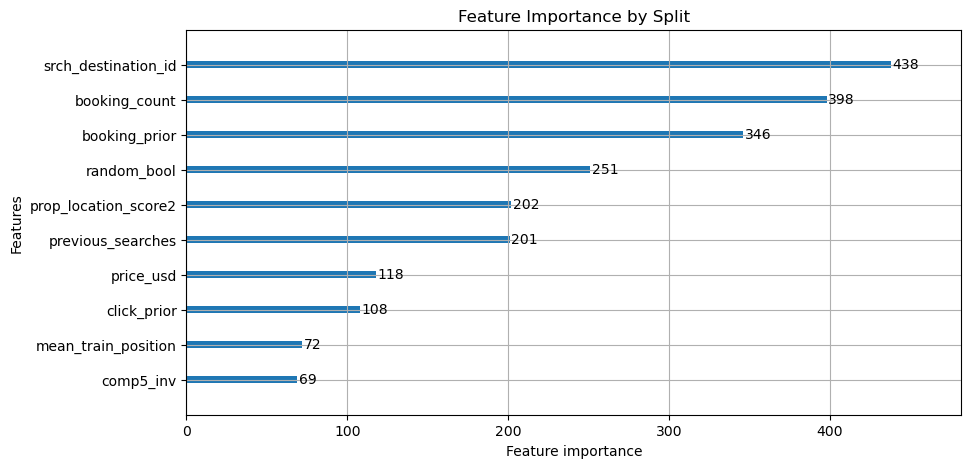

In [14]:
# Format the date and time as a string
datetime_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model = lgb.Booster(model_file=f'best_lambdamart_model.txt')

lgb.plot_importance(model, importance_type='split', max_num_features=10, figsize=(10, 5), title='Feature Importance by Split')

# Predict on the test set
y_pred = model.predict(X_test)

# Add predictions to the test set
test_df['predicted_score'] = y_pred

# Select only the required columns
test_df = test_df[['srch_id', 'prop_id', 'predicted_score']]

# Sort properties for each search by predicted score
test_df = test_df.sort_values(by=['srch_id', 'predicted_score'], ascending=[True, False])

# Create the submission file in the required format
submission = test_df[['srch_id', 'prop_id']]

# Format the date and time as a string
datetime_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the submission file with the date and time in the filename
submission.to_csv(f'submissions/lambdaMART_submission_estimator200.csv', index=False)

# Verify the submission file format
print(submission.head(5))
print(f'Submission shape: {submission.shape}')